In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob

import tensorflow as tf

from sklearn.cluster import KMeans
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering

from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_decision_forests as tfdf

from sklearn.datasets import make_classification

print(tf.__version__)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2.8.0


### Club all the traces together into a single dataframe

In [73]:
#path = './traces_core'# use your path
#all_files = glob.glob(path + "/*.h5")

all_files = []
li = []


trace =  pd.HDFStore('./traces_outlier/dpotrf_T-200_C-1-0.prof.h5')
df_C_1_Tace_0 = trace.get('/events')
trace.close()
trace =  pd.HDFStore('./traces_outlier/dpotrf_T-200_C-1-1.prof.h5')
df_C_1_Tace_1 = trace.get('/events')
trace.close()
frames = [df_C_1_Tace_0, df_C_1_Tace_1]
df_C_1 = pd.concat(frames)
li.append(df_C_1)


In [74]:
print(len(li))

1


In [75]:
li[0].head()

,msg_size,type,src,id,node_id,stream_id,flags,end,taskpool_id,begin,...,tpid,dst,priority,l2,nb_data_items,task_class_id,chore_id,total_data_size,l1,l3
0,120,10,0,0,0,1,1,4112105430,-1,4112093920,...,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,120,10,0,0,0,1,1,4112262858,-1,4112262154,...,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,320000,12,0,0,0,1,1,4113714764,-1,4112871966,...,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,320000,12,0,0,0,1,1,4113714764,-1,4113067735,...,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,120,10,0,0,0,1,1,4113309888,-1,4113308174,...,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Clean the data

In [76]:
for i in range(0, len(li)):
    filter = ( (li[i]['task_class_id'] >= 0 ) & ( li[i]['task_class_id'] <= 3 ) & ( li[i]['priority'] >= 0 ) )
    #remove all other classes other than dpotrf, dgemm, trsm and syrk
    li[i] = li[i][filter]
    #df.head()

In [77]:
li[i].head()

,msg_size,type,src,id,node_id,stream_id,flags,end,taskpool_id,begin,...,tpid,dst,priority,l2,nb_data_items,task_class_id,chore_id,total_data_size,l1,l3
2,NaN,3,NaN,100,0,0,1,1431493,2,536247,...,NaN,NaN,0,2,2,1,0,320000,0,0
3,NaN,3,NaN,0,0,0,1,1840405,2,1440693,...,NaN,NaN,0,1,2,1,0,320000,0,1
4,NaN,3,NaN,400,0,0,1,2734962,2,1845035,...,NaN,NaN,0,5,2,1,0,320000,0,0
5,NaN,3,NaN,300,0,0,1,3139344,2,2739650,...,NaN,NaN,0,4,2,1,0,320000,0,0
6,NaN,3,NaN,200,0,0,1,3589266,2,3143487,...,NaN,NaN,0,3,2,1,0,320000,0,0


In [78]:
for i in range(0, len(li)):
    li[i] = li[i][['begin', 'end', 'taskpool_id', 'task_class_id','chore_id', 'nb_data_items', 'total_data_size', 'priority', 'l1', 'l2', 'l3']].copy()
    li[i]['exec_time'] = (li[i]['end'] - li[i]['begin']) * .001 #0.001 nano seconds to micro seconds
    li[i] = li[i].astype(float)

In [79]:
df_class_name = {0: 'dpotrf', 1: 'dtrsm', 2: 'dsyrk', 3: 'dgemm'}

In [80]:
for i in range(0, len(li)):
    li[i].reset_index(drop=True, inplace=True)

In [81]:
df = li[i]

In [82]:
task_class_id = [0,1,2,3]

for i in task_class_id:
    
    df_exaxmple = df
    
    filter = (df_exaxmple['task_class_id'] == i )
    df_refined = df_exaxmple[filter]
    
    print('----------------- ' + df_class_name[i] + ' [ALL] -------------------------- ')
    print('Min = ' + str(df_refined['exec_time'].min()))
    print('Max = ' + str(df_refined['exec_time'].max()))
    print('Avg = ' + str(sum(df_refined['exec_time']) / len(df_refined['exec_time'])))
    print('Std = ' + str(df_refined['exec_time'].std()))
    datapoint1 = df_refined.shape[0]
    

----------------- dpotrf [ALL] -------------------------- 
Min = 263.187
Max = 16707.798
Avg = 537.3049699999997
Std = 1618.0256946877212
----------------- dtrsm [ALL] -------------------------- 
Min = 399.067
Max = 86898.546
Avg = 1275.7495657912464
Std = 2996.6284612357385
----------------- dsyrk [ALL] -------------------------- 
Min = 308.907
Max = 99235.489
Avg = 890.8086667986844
Std = 3070.89036345924
----------------- dgemm [ALL] -------------------------- 
Min = 485.963
Max = 159915.497
Avg = 1220.946640591703
Std = 3472.0824640681694


In [101]:
task_class_id = [0,1,2,3]
li = []

for i in task_class_id:
    
    df_exaxmple = df
    
    filter = (df_exaxmple['task_class_id'] == i )
    df_refined = df_exaxmple[filter]
    
    Q1 = df_refined['exec_time'].quantile(0.25)
    Q3 = df_refined['exec_time'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter =  (df_refined['exec_time'] >= Q3 + 130 * 1.5 *IQR)
    df_refined = df_refined.loc[filter]
    df_refined = df_refined.astype(float)
    
    print('----------------- ' + df_class_name[i] + ' [Outlier] -------------------------- ')
    print('Min = ' + str(df_refined['exec_time'].min()))
    print('Max = ' + str(df_refined['exec_time'].max()))
    print('Avg = ' + str(sum(df_refined['exec_time']) / len(df_refined['exec_time'])))
    print('Std = ' + str(df_refined['exec_time'].std()))

    li.append(df_refined)

----------------- dpotrf [Outlier] -------------------------- 
Min = 6022.904
Max = 16707.798
Avg = 10387.262428571428
Std = 3613.9442268572184
----------------- dtrsm [Outlier] -------------------------- 
Min = 82997.03600000001
Max = 86898.546
Avg = 84661.966
Std = 2012.5935659988554
----------------- dsyrk [Outlier] -------------------------- 
Min = 6559.433
Max = 99235.489
Avg = 13832.776548148151
Std = 9474.052384979526
----------------- dgemm [Outlier] -------------------------- 
Min = 7507.561000000001
Max = 159915.497
Avg = 13705.94271813895
Std = 9903.788465325064


In [102]:
df_outlier = pd.concat(li, axis=0, ignore_index=True)

In [103]:
df.head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,l1,l2,l3,exec_time
0,536247.0,1431493.0,2.0,1.0,0.0,2.0,320000.0,0.0,0.0,2.0,0.0,895.246
1,1440693.0,1840405.0,2.0,1.0,0.0,2.0,320000.0,0.0,0.0,1.0,1.0,399.712
2,1845035.0,2734962.0,2.0,1.0,0.0,2.0,320000.0,0.0,0.0,5.0,0.0,889.927
3,2739650.0,3139344.0,2.0,1.0,0.0,2.0,320000.0,0.0,0.0,4.0,0.0,399.694
4,3143487.0,3589266.0,2.0,1.0,0.0,2.0,320000.0,0.0,0.0,3.0,0.0,445.779


In [104]:
df.tail()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,l1,l2,l3,exec_time
530245,3.471109e+11,3.471114e+11,12.0,1.0,0.0,2.0,640000.0,19.0,97.0,99.0,0.0,496.680
530246,3.471114e+11,3.471118e+11,12.0,2.0,0.0,2.0,640000.0,10.0,96.0,99.0,8.0,355.801
530247,3.471119e+11,3.471123e+11,12.0,2.0,0.0,2.0,640000.0,7.0,97.0,99.0,8.0,359.038
530248,3.471132e+11,3.471136e+11,12.0,2.0,0.0,2.0,640000.0,4.0,98.0,99.0,8.0,350.555
530249,3.471136e+11,3.471139e+11,12.0,0.0,0.0,1.0,320000.0,1.0,99.0,4.0,764069915.0,267.551


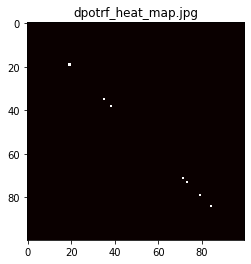

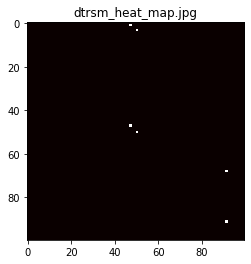

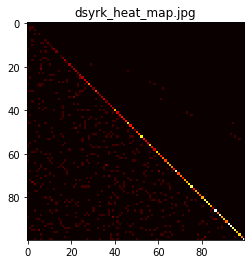

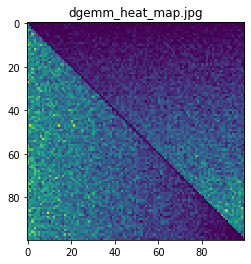

In [105]:
task_class_id = [0,1,2,3]
li = []

for i in task_class_id:
    
    df_exaxmple = df_outlier
    
    filter = (df_exaxmple['task_class_id'] == i )
    df_refined = df_exaxmple[filter]
    
    if(i == 0): #potrf
        mat = np.zeros((100, 100))
        for index, row in df_refined.iterrows():
            k  = int(row['l1'])
            mat[k][k] = mat[k][k] + 1
            
        plt.imshow(mat, cmap='hot', interpolation='nearest')
        #ax = sns.heatmap(mat, linewidth=0.5)
        plt.title(df_class_name[i] + '_heat_map.jpg')
        #plt.savefig(df_class_name[i] + '_heat_map.jpg')
        plt.savefig('heat_map_' + df_class_name[i] +'.jpg')
        plt.show()
        
    if(i == 1): #trsm
        mat = np.zeros((100, 100))
        for index, row in df_refined.iterrows():
            m = int(row['l1'])
            k = int(row['l2'])
            mat[m][k] = mat[m][k] + 1
            mat[k][k] = mat[k][k] + 1
            
        plt.imshow(mat, cmap='hot', interpolation='nearest')
        #ax = sns.heatmap(mat, linewidth=0.5)
        plt.title(df_class_name[i] + '_heat_map.jpg')
        #plt.savefig(df_class_name[i] + '_heat_map.jpg')
        plt.savefig('heat_map_' + df_class_name[i] +'.jpg')
        plt.show()
        
    if(i == 2): #syrk
        mat = np.zeros((100, 100))
        for index, row in df_refined.iterrows():
            k = int(row['l1'])
            m = int(row['l2'])
            mat[m][k] = mat[m][k] + 1
            mat[m][m] = mat[m][m] + 1
            
        plt.imshow(mat, cmap='hot', interpolation='nearest')
        #ax = sns.heatmap(mat, linewidth=0.5)
        plt.title(df_class_name[i] + '_heat_map.jpg')
        #plt.savefig(df_class_name[i] + '_heat_map.jpg')
        plt.savefig('heat_map_' + df_class_name[i] +'.jpg')
        plt.show()
        
    if(i == 3): #gemm
        mat = np.zeros((100, 100))
        for index, row in df_refined.iterrows():
            k = int(row['l1'])
            m = int(row['l2'])
            n = int(row['l3'])
            #mat[m][n] = mat[m][n] + 1
            mat[m][n] = mat[m][n] + 1
            mat[m][k] = mat[m][k] + 1
            mat[n][k] = mat[n][k] + 1
            
        plt.imshow(mat, interpolation='nearest')
        #ax = sns.heatmap(mat, linewidth=0.5)
        plt.title(df_class_name[i] + '_heat_map.jpg')
        #plt.savefig(df_class_name[i] + '_heat_map.jpg')
        plt.savefig('heat_map_' + df_class_name[i] +'.jpg')
        plt.show()
        
    

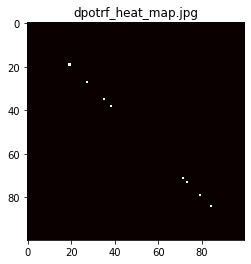

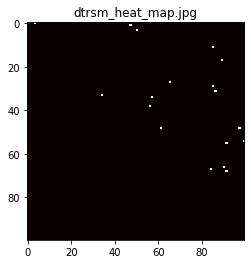

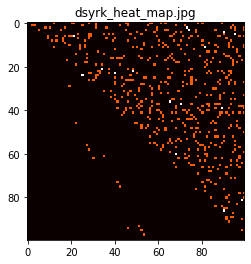

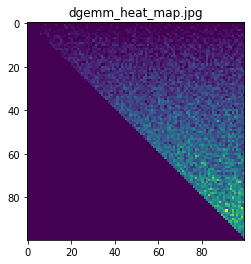

In [92]:
task_class_id = [0,1,2,3]
li = []

for i in task_class_id:
    
    df_exaxmple = df_outlier
    
    filter = (df_exaxmple['task_class_id'] == i )
    df_refined = df_exaxmple[filter]
    
    if(i == 0): #potrf
        mat = np.zeros((100, 100))
        for index, row in df_refined.iterrows():
            k  = int(row['l1'])
            mat[k][k] = mat[k][k] + 1
            
        plt.imshow(mat, cmap='hot', interpolation='nearest')
        #ax = sns.heatmap(mat, linewidth=0.5)
        plt.title(df_class_name[i] + '_heat_map.jpg')
        #plt.savefig(df_class_name[i] + '_heat_map.jpg')
        plt.savefig('heat_map_' + df_class_name[i] +'.jpg')
        plt.show()
        
    if(i == 1): #trsm
        mat = np.zeros((100, 100))
        for index, row in df_refined.iterrows():
            m = int(row['l1'])
            k = int(row['l2'])
            mat[m][k] = mat[m][k] + 1
    
            
        plt.imshow(mat, cmap='hot', interpolation='nearest')
        #ax = sns.heatmap(mat, linewidth=0.5)
        plt.title(df_class_name[i] + '_heat_map.jpg')
        #plt.savefig(df_class_name[i] + '_heat_map.jpg')
        plt.savefig('heat_map_' + df_class_name[i] +'.jpg')
        plt.show()
        
    if(i == 2): #syrk
        mat = np.zeros((100, 100))
        for index, row in df_refined.iterrows():
            k = int(row['l1'])
            m = int(row['l2'])
            mat[k][m] = mat[k][m] + 1
        
            
        plt.imshow(mat, cmap='hot', interpolation='nearest')
        #ax = sns.heatmap(mat, linewidth=0.5)
        plt.title(df_class_name[i] + '_heat_map.jpg')
        #plt.savefig(df_class_name[i] + '_heat_map.jpg')
        plt.savefig('heat_map_' + df_class_name[i] +'.jpg')
        plt.show()
        
    if(i == 3): #gemm
        mat = np.zeros((100, 100))
        for index, row in df_refined.iterrows():
            k = int(row['l1'])
            m = int(row['l2'])
            n = int(row['l3'])
            #mat[m][n] = mat[m][n] + 1
            mat[m][n] = mat[m][n] + 1
            
        plt.imshow(mat, interpolation='nearest')
        #ax = sns.heatmap(mat, linewidth=0.5)
        plt.title(df_class_name[i] + '_heat_map.jpg')
        #plt.savefig(df_class_name[i] + '_heat_map.jpg')
        plt.savefig('heat_map_' + df_class_name[i] +'.jpg')
        plt.show()
        
    